<a href="https://colab.research.google.com/github/sohyeon98720/doitDeeplearning/blob/master/doitDeeplearning_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 8강 : 합성곱 신경망
# 합성곱에 대한 설명
import numpy as np
w=np.array([2,1,5,3])
x=np.array([2,8,3,7,1,2,0,4,5])

In [2]:
w_r=np.flip(w)
print(w_r)

[3 5 1 2]


In [3]:
for i in range(len(x)-len(w)+1):
  print(np.dot(x[i:i+4],w_r))

63
48
49
28
21
20


In [4]:
from scipy.signal import convolve
convolve(x,w,mode='valid')

array([63, 48, 49, 28, 21, 20])

In [5]:
# 합성곱과 교차상관이 다른 점 : 미끄러지는 배열이 뒤집어져있는지, 똑바론지
from scipy.signal import correlate
correlate(x,w,mode='valid')
# 가중치가 어차피 무작위로 초기화되어있기 때문에 뒤집어져있는지 여부는 중요 X

array([48, 57, 24, 25, 16, 39])

In [6]:
correlate(x,w,mode='full')
# full 패딩은 원본 배열 원소의 연산 참여도를 동일하게 함

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [7]:
correlate(x,w,mode='same')
# same 패딩은 출력 배열의 길이를 원본 배열의 길이와 동일하게 함

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [8]:
x=np.array([[1,2,3],
            [4,5,6],
            [7,8,9]])

w=np.array([[2,0],[0,0]])

from scipy.signal import correlate2d
correlate2d(x,w,mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [9]:
correlate2d(x,w,mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [0]:
# !pip install tensorflow-gpu==2.0.0-rc2
# 위의 문장은 경고나 오류가 뜰 경우만 수행
import tensorflow as tf
x_4d=x.astype(np.float).reshape(1,3,3,1)
w_4d=w.reshape(2,2,1,1)

In [0]:
c_out=tf.nn.conv2d(x_4d,w_4d,strides=1,padding='SAME')

In [13]:
c_out.numpy().reshape(3,3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [0]:
x=np.array([[1,2,3,4],
            [5,6,7,8],
            [9,10,11,12],
            [13,14,15,16]])
x=x.reshape(1,4,4,1)

In [15]:
p_out=tf.nn.max_pool2d(x,ksize=2,strides=2,padding='VALID')
p_out.numpy().reshape(2,2)

array([[ 6,  8],
       [14, 16]])

In [0]:
# 새로운 활성화 함수 : relu
def relu(x):
  return np.maximum(x,0)

In [17]:
x=np.array([-1,2,-3,4,-5])
relu(x)

array([0, 2, 0, 4, 0])

In [18]:
r_out=tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

In [0]:
class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  # 합성곱의 커널 개수
        self.kernel_size = 3        # 커널 크기
        self.optimizer = None       # 옵티마이저
        self.conv_w = None          # 합성곱 층의 가중치
        self.conv_b = None          # 합성곱 층의 절편
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size  # 배치 크기
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        self.lr = learning_rate     # 학습률

    def forpass(self, x):
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        r_out = tf.nn.relu(c_out)
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1
        a1 = tf.nn.relu(z1)                     
        z2 = tf.matmul(a1, self.w2) + self.b2
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        for i in range(epochs):
            print('에포크', i, end=' ')
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            self.losses.append(np.mean(batch_losses))
            self.val_losses.append(self.get_loss(x_val, y_val))

    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size       
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]
            
    def training(self, x, y):
        m = len(x)                  
        with tf.GradientTape() as tape:
            z = self.forpass(x)  
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        grads = tape.gradient(loss, weights_list)
        self.optimizer.apply_gradients(zip(grads, weights_list))
   
    def predict(self, x):
        z = self.forpass(x)               
        return np.argmax(z.numpy(), axis=1)
    
    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

In [20]:
# 데이터셋은 7강과 동일
(x_train_all,y_train_all),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# train, val, test set으로 나누기
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train_all,y_train_all,stratify=y_train_all,test_size=0.2,random_state=42)

In [0]:
# 정답 배열에 대한 원 핫 인코딩 수행
y_train_encoded=tf.keras.utils.to_categorical(y_train)
y_val_encoded=tf.keras.utils.to_categorical(y_val)

In [0]:
# 컬러를 나타내는 차원 추가하기
x_train=x_train.reshape(-1,28,28,1)
x_val=x_val.reshape(-1,28,28,1)

In [25]:
x_train.shape

(48000, 28, 28, 1)

In [0]:
x_train=x_train/255.0
x_val=x_val/255.0

In [27]:
cn=ConvolutionNetwork(n_kernels=10,units=10,batch_size=128,learning_rate=0.01)
cn.fit(x_train,y_train_encoded,x_val=x_val,y_val=y_val_encoded,epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

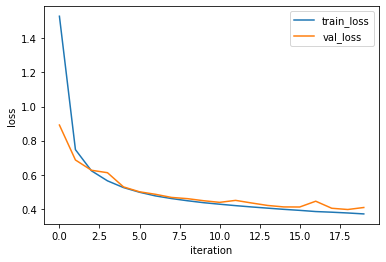

In [28]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

In [29]:
# 7강의 맨마지막 코드와 비교
cn.score(x_val,y_val_encoded)

0.861

In [0]:
# keras로 합성곱 층 만들기
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense

conv1=tf.keras.Sequential()
conv1.add(Conv2D(10,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
conv1.add(MaxPooling2D((2,2)))
conv1.add(Flatten())
conv1.add(Dense(100,activation='relu'))
conv1.add(Dense(10,activation='softmax'))

In [31]:
# conv1의 구조를 볼 수 있는 명령어
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
history=conv1.fit(x_train,y_train_encoded,epochs=20,validation_data=(x_val,y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 25s 523us/sample - loss: 0.4460 - accuracy: 0.8421 - val_loss: 0.3271 - val_accuracy: 0.8848
Epoch 2/20
48000/48000 [==============================] - 24s 507us/sample - loss: 0.3058 - accuracy: 0.8914 - val_loss: 0.2925 - val_accuracy: 0.8936
Epoch 3/20
48000/48000 [==============================] - 24s 508us/sample - loss: 0.2649 - accuracy: 0.9030 - val_loss: 0.2713 - val_accuracy: 0.9016
Epoch 4/20
48000/48000 [==============================] - 28s 586us/sample - loss: 0.2340 - accuracy: 0.9134 - val_loss: 0.2514 - val_accuracy: 0.9091
Epoch 5/20
48000/48000 [==============================] - 32s 659us/sample - loss: 0.2115 - accuracy: 0.9215 - val_loss: 0.2452 - val_accuracy: 0.9133
Epoch 6/20
48000/48000 [==============================] - 31s 654us/sample - loss: 0.1880 - accuracy: 0.9309 - val_loss: 0.2505 - val_accuracy: 0.9119
Epoch 7/20
48000/48000 [====================

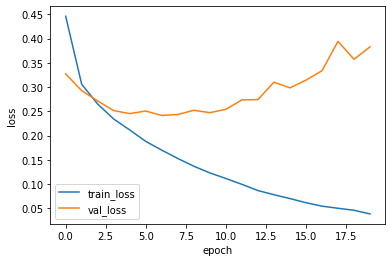

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()
# overfitting이 되었음을 알 수 있음

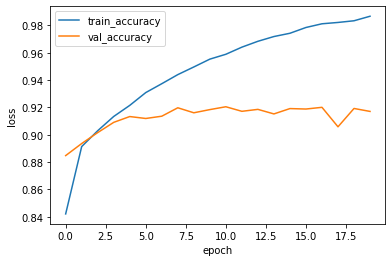

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [0]:
# 위의 overfitting현상을 막기 위한 dropout
from tensorflow.keras.layers import Dropout

conv2=tf.keras.Sequential()
conv2.add(Conv2D(10,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
conv2.add(MaxPooling2D(2,2))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100,activation='relu'))
conv2.add(Dense(10,activation='softmax'))

In [37]:
conv2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [38]:
conv2.compile(optimizers='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history=conv2.fit(x_train,y_train_encoded,epochs=20,validation_data=(x_val,y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 41s 844us/sample - loss: 0.5014 - accuracy: 0.8210 - val_loss: 0.3644 - val_accuracy: 0.8701
Epoch 2/20
48000/48000 [==============================] - 39s 815us/sample - loss: 0.3793 - accuracy: 0.8630 - val_loss: 0.3207 - val_accuracy: 0.8850
Epoch 3/20
48000/48000 [==============================] - 39s 805us/sample - loss: 0.3446 - accuracy: 0.8757 - val_loss: 0.2982 - val_accuracy: 0.8943
Epoch 4/20
48000/48000 [==============================] - 43s 890us/sample - loss: 0.3244 - accuracy: 0.8840 - val_loss: 0.2928 - val_accuracy: 0.8927
Epoch 5/20
48000/48000 [==============================] - 42s 865us/sample - loss: 0.3165 - accuracy: 0.8869 - val_loss: 0.2800 - val_accuracy: 0.9017
Epoch 6/20
48000/48000 [==============================] - 44s 917us/sample - loss: 0.3059 - accuracy: 0.8905 - val_loss: 0.2712 - val_accuracy: 0.9060
Epoch 7/20
48000/48000 [====================

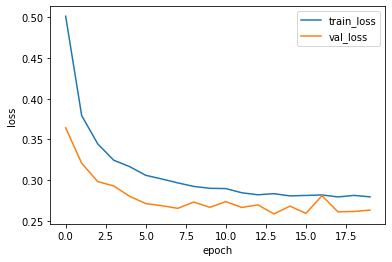

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

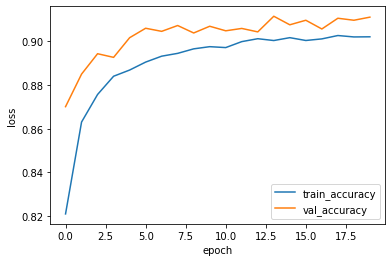

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [0]:
loss, accuracy = conv2.evaluate(x_val, y_val_encoded, verbose=0)

In [42]:
print(accuracy)

0.91108334
